## PROJECT DESCRIPTION

You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.  
In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.  
The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

### Table of Contents <a class="anchor" id="contents"></a>

* [Importing libraries + first glance at data](#chapter1)
* [Data preprocessing](#chapter2) 
* [Analysis](#chapter3)
* [Regional research](#chapter4)
* [Testing hypotheses](#chapter5)
* [General conclusions](#chapter6)

### Importing libraries + first glance at data  <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seaborn as sn
import squarify
from scipy import stats as st

In [2]:
games = pd.read_csv('games.csv')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [5]:
games.describe(include=['object'])

,Name,Platform,Genre,User_Score,Rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


So what we see from the very first glance:  
**16 715** entries of different games and their data (sales, rating, user_score) throughout 36 years.  

- 'Name' - there are 2 empty rows, need check, maybe just delete if it is wrong data
- 'Platform' - 31 different platforms, no missing data, PS2 is the most frequent
- 'Year of Release' - floating number, it is better in integer. Missing data - need check
- 'Genre' - 12 unique genres, but 2 empty rows, need check
- NA, EU, JP and other sales - dont have missing values, but very big number of zeros which means 1) mistakes during data collection 2) no data release in particular area. As soon as we need to investigate the influence on sales, zeros should checked, and at least delete all rows with total zero sales
- 'Critic_Score' - has a big number of missing values, but it is possible because the game could not recieve critic score. Or it is data collection error. I am not sure the data could be retrieved, maybe on average scores.
- 'User_Score' - the most common value is 'tbd' (to be determined), plus missing values. I suppose the data supposed to be retrieved from other columns - but need closer check. Object type!
- 'Rating' - have some missing values, I dont think it could be anyhow retrieved because it is some category attributed to the game by the ESRB organization and it hardly could be retrieved logically, it is a fact defined by particular dicision.

[back to contents](#contents)

### Data preprocessing <a class="anchor" id="chapter2"></a>

In [6]:
#naking columns names more comfortable to use (they had capitals laters in titles)
games.columns = games.columns.str.lower()

#### Missing values 

In [7]:
games[games['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


I assume these two rows could be deleted because they dont it is impossible to retrieve with available information.

In [8]:
games.drop(games[games['name'].isnull()].index, inplace=True)

**Year of release** is tricky and its difficult to retrieve the missing data.  
I have tried to fill in some missing cells with the columns I know. So I have created the new column based on the column "name" and known year releases for the games. It actually helped, but still some years were missing.  
I have also noticed that in some names of the games there are years in titles. I looked through the list of unique game titles with missing years and found some titles which could be used for replacement. I replaced the values manually, I am not sure if any automation is possible here as soon as I choose which values to replace manually regarding the content.  
But still 139 is empty, it is **1% of data**.

In [9]:
games["year_new"] = games.groupby('name')["year_of_release"].transform('min')

In [10]:
games[games['year_new'].isnull()]['name'].unique()
games[(games['name'].str.contains("2006|2007|2008|2011|2003|2005", regex=True)) & games['year_new'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_new
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,NaN
4775,NFL GameDay 2003,PS2,NaN,Sports,0.20,0.15,0.00,0.05,60.0,tbd,E,NaN
5655,All-Star Baseball 2005,PS2,NaN,Sports,0.16,0.12,0.00,0.04,72.0,8.6,E,NaN
8918,All-Star Baseball 2005,XB,NaN,Sports,0.11,0.03,0.00,0.01,75.0,8.8,E,NaN
13195,Tour de France 2011,X360,NaN,Racing,0.00,0.04,0.00,0.01,46.0,7.6,NaN,NaN
13929,Sega Rally 2006,PS2,NaN,Racing,0.00,0.00,0.04,0.00,NaN,NaN,NaN,NaN
16079,Football Manager 2007,X360,NaN,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,NaN


In [11]:
games.loc[(games['name'] == 'wwe Smackdown vs. Raw 2006'), 'year_new'] = 2006
games.loc[(games['name'] == 'NFL GameDay 2003'), 'year_new'] = 2003
games.loc[(games['name'] == 'All-Star Baseball 2005'), 'year_new'] = 2005
games.loc[(games['name'] == 'Tour de France 2011'), 'year_new'] = 2011
games.loc[(games['name'] == 'Sega Rally 2006'), 'year_new'] = 2006
games.loc[(games['name'] == 'Football Manager 2007'), 'year_new'] = 2007

In [12]:
print('Missing values in year: {:.2%}'.format(games['year_new'].isnull().sum() / len(games)))

Missing values in year: 0.83%


In [13]:
games['year_new'] = games['year_new'].fillna(0).astype('int')

**User and critic scores** are crucial so  needed to be retrieved in as much volume as possible.  
I have started from converting 'tbd' values to missing values, then I have converted the strings into floating number. And I have replaced missing values two times:  
- first iteration - comparing games by names and taking their scores from other platforms  
- second - to all missing walues that remained I have applied median value by genres (it seems to the only option of retrieving the data - genres are extremely important for game evaluation because it is difficult to compare some super active shooter and indie art house quest for example, and median is more appopriate here because mean could be affected by extreme low and high scores and we need more or less reliable value to fill in missings)


In [14]:
games['user_score_new'] = games['user_score']
games['user_score_new'] = games['user_score_new'].replace('tbd', np.nan)
games['user_score_new'] = pd.to_numeric(games['user_score_new'],errors='coerce').round(decimals=1)
games['user_score_new'].fillna(games.groupby(['name'])['user_score_new'].transform('median'),inplace=True)
games['user_score_new'].fillna(games.groupby(['genre'])['user_score_new'].transform('median'),inplace=True)

In [15]:
games['critic_score_new'] = games['critic_score']
games['critic_score_new'].fillna(games.groupby(['name'])['critic_score_new'].transform('median'),inplace=True)
games['critic_score_new'].fillna(games.groupby(['genre'])['critic_score_new'].transform('median'),inplace=True)

As I mentioned above **rating** is a value assigned to a game by special organization. The only option that is possible - to get data from additional sources, checking all the games for their final rating, parcing the ESRB catalogues for the necessary data.  
"RP" means 'rating pending' - it is an intemediary status for the games, so I think I can replace NaN with this status.  
Also I have checked that "K-A" rating is no longer used, it is "E" (Everyone) now, so I will replace it too.

In [16]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [17]:
games['rating'] = games['rating'].replace('K-A','E')
games['rating'].value_counts()

E       3993
T       2961
M       1563
E10+    1420
EC         8
RP         3
AO         1
Name: rating, dtype: int64

In [18]:
games_rating = games.pivot_table(index='genre', columns='rating', values = 'name', aggfunc='count')
games_rating
#Action - T
#Adventure - E
#Fighting - T
#Misc - E
#Platform - E
#Puzzle - E
#Racing - E
#Role-Playing - T
#Shooter - M
#Simulation - E
#Sports - E
#Strategy - T

rating,AO,E,E10+,EC,M,RP,T
genre,,,,,,,
Action,1.0,416.0,481.0,1.0,608.0,NaN,681.0
Adventure,NaN,162.0,68.0,2.0,99.0,NaN,115.0
Fighting,NaN,8.0,19.0,NaN,49.0,NaN,362.0
Misc,NaN,458.0,167.0,5.0,13.0,NaN,239.0
Platform,NaN,358.0,144.0,NaN,3.0,NaN,64.0
Puzzle,NaN,289.0,43.0,NaN,NaN,NaN,10.0
Racing,NaN,585.0,96.0,NaN,18.0,1.0,172.0
Role-Playing,NaN,84.0,111.0,NaN,162.0,NaN,420.0
Shooter,NaN,48.0,58.0,NaN,565.0,NaN,348.0


In [19]:
rating_fillna = games[games.rating.isnull()].copy()
len(rating_fillna)

6764

In [20]:
def genre_rating(row):
    genre = row['genre']
    if genre == 'Action' or genre == 'Fighting' or genre == 'Role-Playing' or genre == 'Strategy':
        return 'T'
    elif genre == 'Shooter':
        return 'M'
    else:
        return 'E'

rating_fillna['rating'] = rating_fillna.apply(genre_rating, axis=1)

rating_fillna['rating'].value_counts()

E    3803
T    2657
M     304
Name: rating, dtype: int64

In [21]:
rating_fillna.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_new,user_score_new,critic_score_new
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,E,1985,7.6,69.0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,T,1996,7.9,74.0
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,E,1988,7.5,70.0
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,M,1984,7.4,73.0
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,E,2005,7.6,70.0


In [22]:
games = games.drop(games[games.rating.isnull()].index)
frames = [games, rating_fillna]
games_new = pd.concat(frames, sort=False)

**Total sales**  
Remembering that there are a lot of zeros in jp_sales and other sales I have checked if there are total sales equal zeros which means that there were no launches or no sales regarding different factors. It is just two games which I think I can drop because they are no interest in studying sales.

In [23]:
games_new['total_sales'] = games_new[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [24]:
games_new[games_new['total_sales']==0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_new,user_score_new,critic_score_new,total_sales
16676,G1 Jockey 4 2008,PS3,2008.0,Sports,0.0,0.0,0.0,0.0,NaN,NaN,E,2008,7.4,75.0,0.0
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.0,0.0,0.0,0.0,NaN,NaN,E,2008,7.3,69.0,0.0


In [25]:
games_new.drop(games_new[games_new['total_sales'] == 0].index, inplace=True)
games_new = games_new.drop(columns=['year_of_release', 'critic_score', 'user_score'])

In [26]:
games_new.columns = ['name','platform','genre',
                     'na_sales','eu_sales','jp_sales', 'other_sales', 'rating', 'year_of_release', 'user_score', 'critic_score', 'total_sales']

In [27]:
games_new.head()

,name,platform,genre,na_sales,eu_sales,jp_sales,other_sales,rating,year_of_release,user_score,critic_score,total_sales
0,Wii Sports,Wii,Sports,41.36,28.96,3.77,8.45,E,2006,8.0,76.0,82.54
2,Mario Kart Wii,Wii,Racing,15.68,12.76,3.79,3.29,E,2008,8.3,82.0,35.52
3,Wii Sports Resort,Wii,Sports,15.61,10.93,3.28,2.95,E,2009,8.0,80.0,32.77
6,New Super Mario Bros.,DS,Platform,11.28,9.14,6.50,2.88,E,2006,8.5,89.0,29.80
7,Wii Play,Wii,Misc,13.96,9.18,2.93,2.84,E,2006,6.6,58.0,28.91


[back to contents](#contents)

### Analysis  <a class="anchor" id="chapter3"></a>

- **How many games were released in different years?**

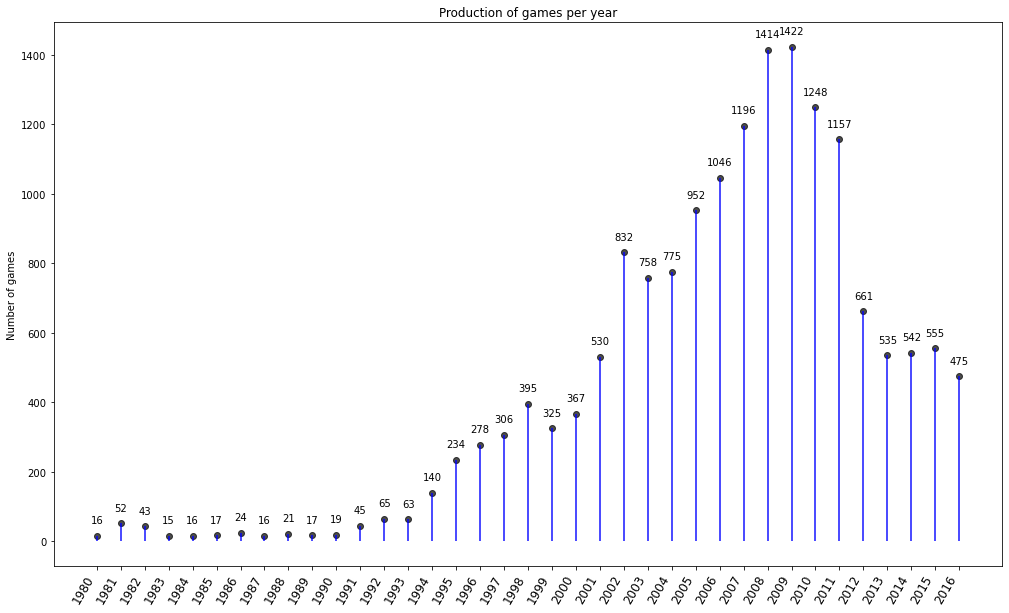

In [28]:
games_by_years = games_new[['name', 'year_of_release']].groupby('year_of_release').count().reset_index()
games_by_years = games_by_years[games_by_years['year_of_release'] != 0]
fig,ax=plt.subplots(figsize=(17,10))
ax.vlines(x=games_by_years['year_of_release'], ymin=0, ymax=games_by_years['name'], color='blue', alpha=0.7, linewidth=2)
ax.scatter(x=games_by_years['year_of_release'], y=games_by_years['name'], color='black', alpha=0.7)
ax.set_title('Production of games per year')
ax.set_ylabel("Number of games")
ax.set_xticks(games_by_years['year_of_release'])
ax.set_xticklabels(games_by_years['year_of_release'], rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
for row in games_by_years.itertuples():
    ax.text(row.year_of_release, row.name+30, s=round(row.name, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=10)
plt.show()

I have grouped games by year and names and calculated the distribution across the years (taking into account that the same game could be released on different platforms).  
As we see years 2005-2010 were the most 'fruitful' concerning game production.  
Alternatively before 1995 the speed of game release was significantly lower.

2016 looks average since 2010.

- **How sales varied from platform to platform? Which  had the biggest sales? the lowest? How long does it generally take for new platforms to appear and old ones to fade?**

In [29]:
platforms = games_new[['platform', 'total_sales']].groupby('platform').sum().sort_values(by='total_sales').reset_index()
platforms.head()

,platform,total_sales
0,PCFX,0.03
1,GG,0.04
2,3DO,0.10
3,TG16,0.16
4,WS,1.42


In [30]:
platforms['sales_z'] = (platforms['total_sales'] - platforms['total_sales'].mean()) / platforms['total_sales'].std()
platforms['colors'] = ['red' if x<0 else 'green' for x in platforms['sales_z']]

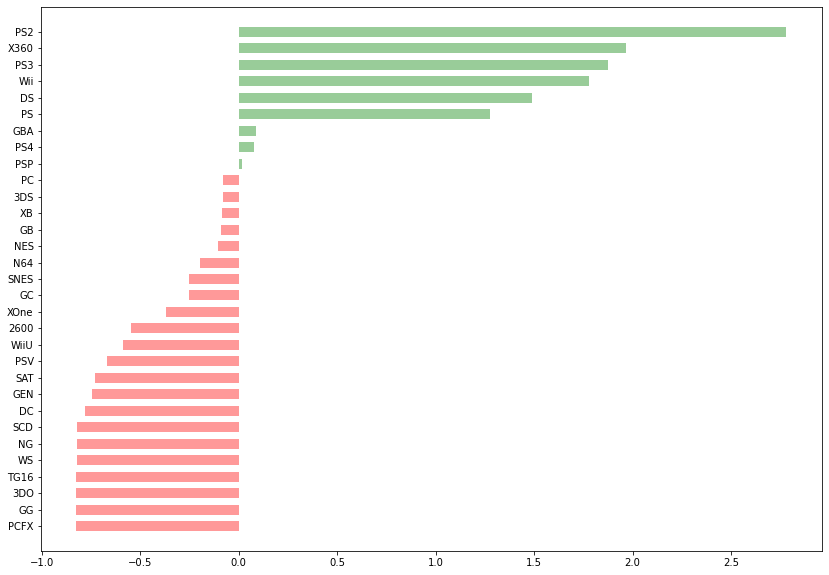

In [31]:
plt.figure(figsize=(14,10))
plt.hlines(y=platforms['platform'], xmin=0, xmax = platforms['sales_z'], color=platforms['colors'], alpha=0.4, linewidth=10)
plt.show()

This graph shows the distribution of platform according to the normalized difference in total sales from game to game on the particular platform.
What we see here is the top of the most successful platforms: PS, PS2, X360, PS3, Wii, DS, GBA, PS4, PSP. 

In [32]:
platforms_by_years = pd.pivot_table(games_new, index='year_of_release', columns='platform', values='total_sales', aggfunc=sum, fill_value=0)
platforms_by_years = platforms_by_years[['PS2', 'X360', 'PS3', 'Wii','DS', 'GBA', 'PS4', 'PSP']]

In [33]:
dynamics = platforms_by_years - platforms_by_years.shift(+1)

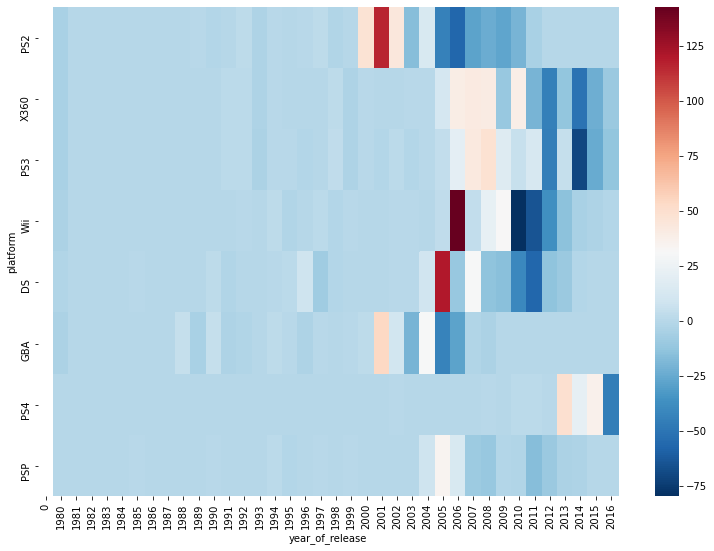

In [34]:
plt.figure(figsize=(13,9))
sns.heatmap(dynamics.T, cmap="RdBu_r")
plt.show()

I have selected the most popular platforms and made distribution of total sales. So what we see: Nintendo products DS and Wii seem to be the most sucessful at time of their launch but the dont last pretty much.
PS2 can be called the best here, and because of successful start and because of longer lasting success. X360 was less sucessful on launch, but it lasted little bit longer than Nintendo, so I would say it performed better than Nintendo but worse than PS2.
GBA and PSP here are the least lasting platforms which lost their audience and games pretty fast.
And it is too early to make conclusions regarding PS4, as soon it is the latest model of PS for that time.

- **Which platforms are leading in sales? Which ones are growing or shrinking?**

Regarding what I have found before, I would say that we need data **since 1995**. Before 1995 there is fewer data and it seems less relevant and we can omit it for the future model

In [35]:
games_1995 = games_new.query('year_of_release >= 1995')
len(games_1995)

16003

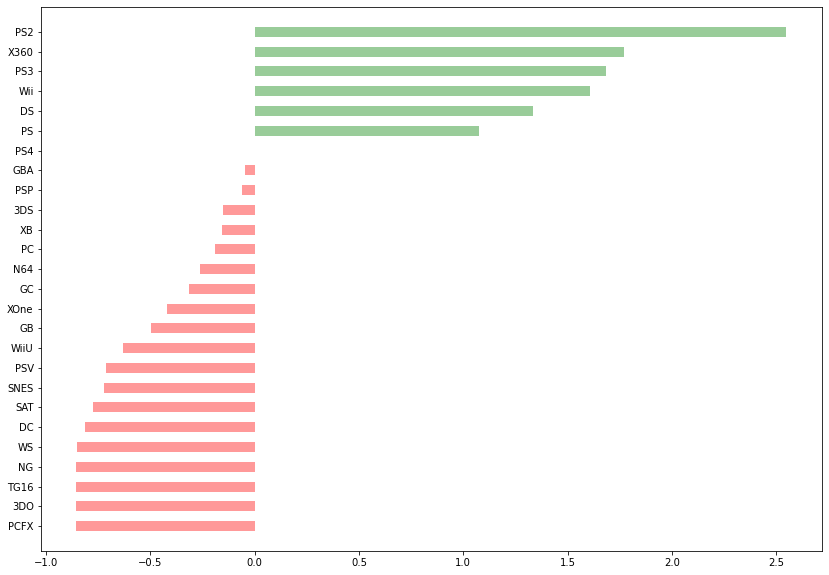

In [36]:
platforms_1995 = games_1995[['platform', 'total_sales']].groupby('platform').sum().sort_values(by='total_sales').reset_index()
platforms_1995['sales_z'] = (platforms_1995['total_sales'] - platforms_1995['total_sales'].mean()) / platforms_1995['total_sales'].std()
platforms_1995['colors'] = ['red' if x<0 else 'green' for x in platforms_1995['sales_z']]
plt.figure(figsize=(14,10))
plt.hlines(y=platforms_1995['platform'], xmin=0, xmax = platforms_1995['sales_z'], color=platforms_1995['colors'], alpha=0.4, linewidth=10)
plt.show()

When reduced the data and excluded some years, we see that the top of platforms reduced, now it is both Nintendo products, PS2/3 and X360.

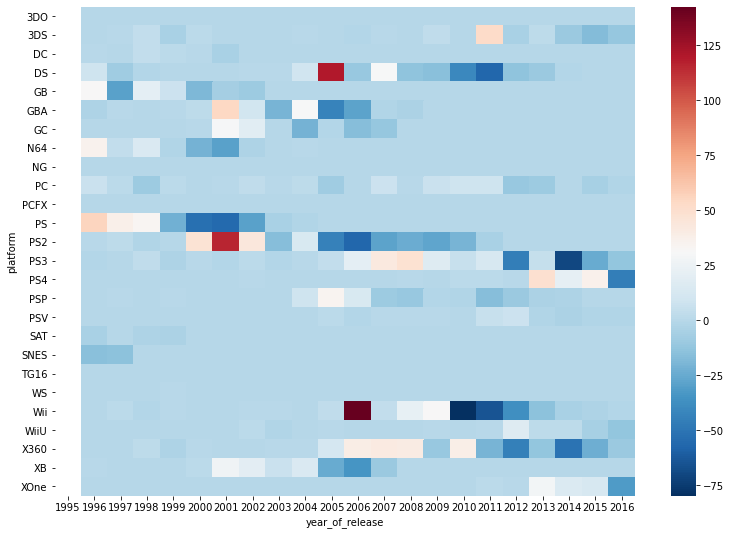

In [37]:
platforms_by_years_1995 = pd.pivot_table(games_1995, index='year_of_release', columns='platform', values='total_sales', aggfunc=sum, fill_value=0)
dynamics_1995 = platforms_by_years_1995 - platforms_by_years_1995.shift(+1)
plt.figure(figsize=(13,9))
sns.heatmap(dynamics_1995.T, cmap="RdBu_r")
plt.show()

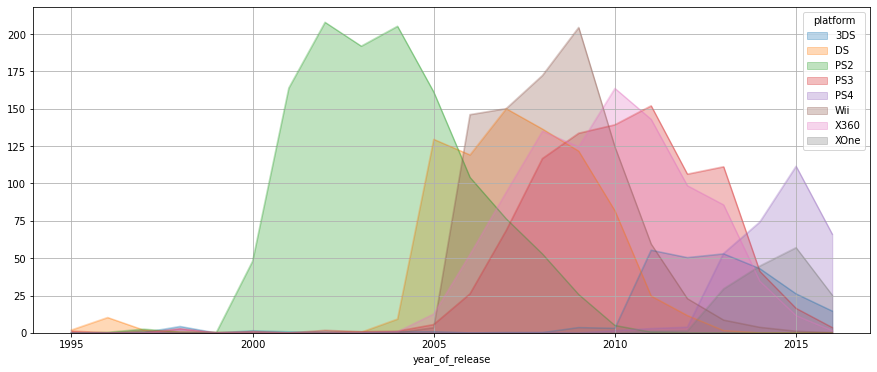

In [38]:
top_platfroms = games_1995.query('platform in ("PS2", "X360", "PS3", "Wii", "DS", "PS4", "3DS", "XOne")')
#platforms_by_years = platforms_by_years[['PS2', 'X360', 'PS3', 'Wii','DS', 'GBA', 'PS4', 'PSP']]
plat_1995 = top_platfroms.pivot_table(index=games_1995['year_of_release'],
                                   columns='platform',
                                   values='total_sales',
                                   aggfunc='sum').plot(kind='area', stacked=False, alpha=0.3, grid=True, figsize=(15,6))


Still PS2 is the winner - the greatest by sales and lasted longer. Nintendo Wii was similar success but also goes down. 
Since 2012 it is time for PS4 and Xbox One and they are growning.

- **Are the differences in sales significant? What about average sales on various platforms?**

In [39]:
grouped = top_platfroms.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

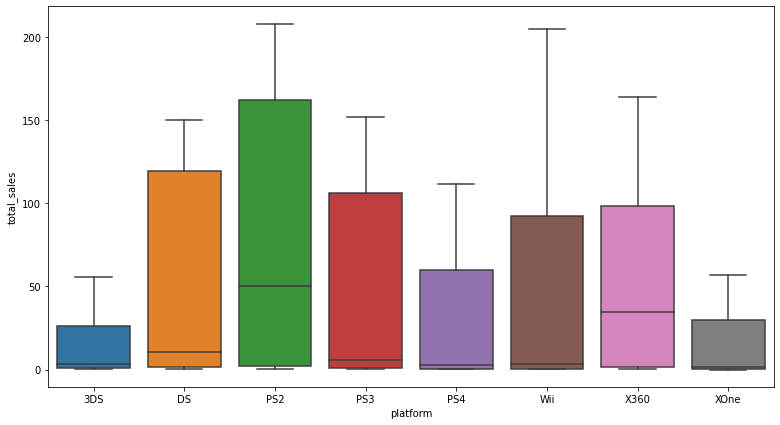

In [40]:
plt.figure(figsize=(13,7))
sns.boxplot(x='platform', y='total_sales', data=grouped)
plt.show()

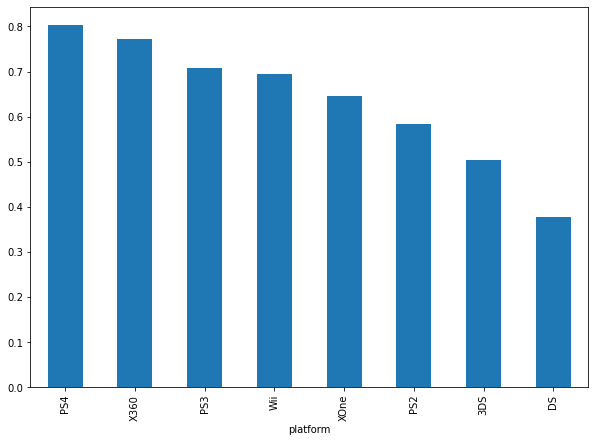

In [41]:
grouped_mean = top_platfroms.groupby('platform')['total_sales'].mean()
grouped_mean.sort_values(axis=0, ascending=False, inplace=True)
grouped_mean.plot(y='total_sales', kind='bar', figsize=(10,7))
plt.show()

So what we see here.Differences are significant.
Boxplots show the excellence of PS2 and Wii, however median total sales of PS2 are higher, on the level of X360 which means that they are more expensive, however Wii was better in total sales than X360 by the end.
DS and PS3 are close by the time of launch and they show similar results, however PS3 median sales are little bit lower.

But what is the picture when we evaluate the platfroms by average total_sales. PS4 is the leader, but it is new and it is supposed to be more "expensive" and there is less data. Comparing X360, Wii amd PS2 like consoles of x360 hs the highest average sales, maybe due to some sucessful releases.
PS2 has lower average sales but still it is more successful platforms among others concerning total sales and its distribution.

- **Is there a correlation between reviews and sales? (by the example of one platform)**

I will choose **Xbox 360** for this analysis.

In [42]:
xbox360 = games_1995.query('platform in "X360"')
print(len(xbox360))

1247


In [43]:
xbox360_new = xbox360[['user_score', 'critic_score', 'total_sales']]

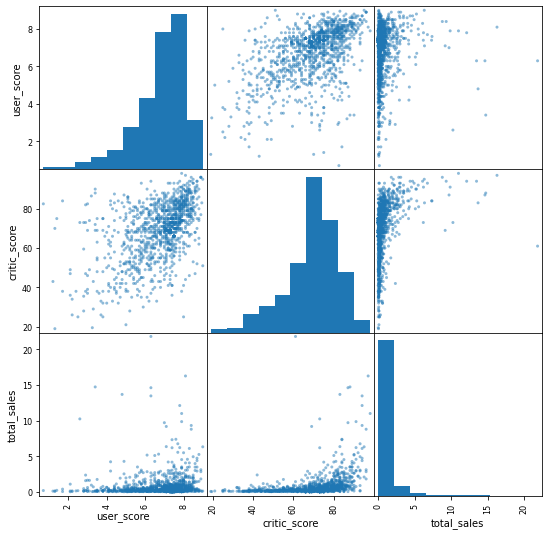

In [44]:
pd.plotting.scatter_matrix(xbox360_new, figsize=(9,9))
plt.show()

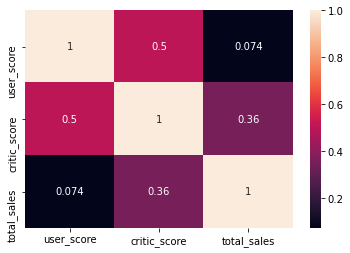

In [45]:
corr_matrix_new = xbox360_new.corr()
sn.heatmap(corr_matrix_new, annot=True)
plt.show()

So on the example of Xbox 360 we see that there is no correlation between sales and user and critic scores. It is interesting because I know that gamers read reviews of the games before buying, but it seems that their curiousity to try the game still prevails:)

- **Do the sales of the same games on other platforms differ?**

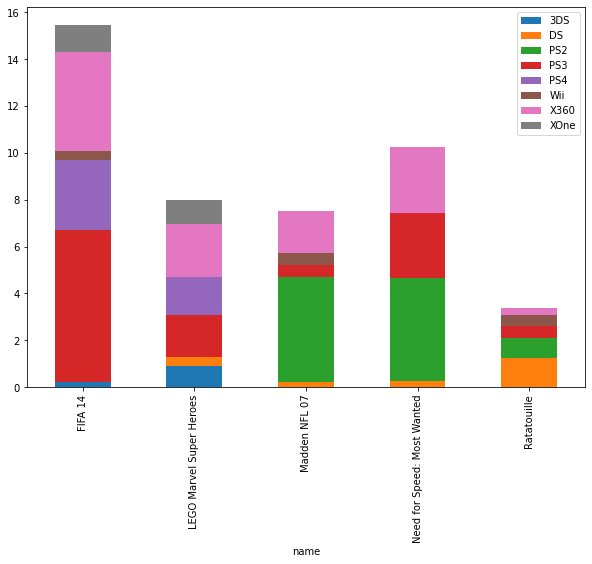

In [46]:
games_pivot = top_platfroms.query('name in ("Need for Speed: Most Wanted", "Ratatouille", "Madden NFL 07", "LEGO Marvel Super Heroes", "FIFA 14")').pivot_table(index='name',
                                     columns='platform',
                                     values='total_sales',
                                     aggfunc=['sum'])
games_pivot.columns = ["3DS", "DS", "PS2", "PS3", "PS4", "Wii", "X360", "XOne"]
games_pivot.plot(kind='bar', stacked=True,figsize=(10,7))
plt.show()

I choose top 5 games and checked their sales across top platforms. As we see, the biggest shares of sales goes to 3 main platforms: PS2, PS3, X360. Wii seems to be leading in different games and also it has less number of gamers, as soon as PlyStation and Xbox are the leading and competing.

- **What are the most profitable genres? Which are genres with high and low sales?**

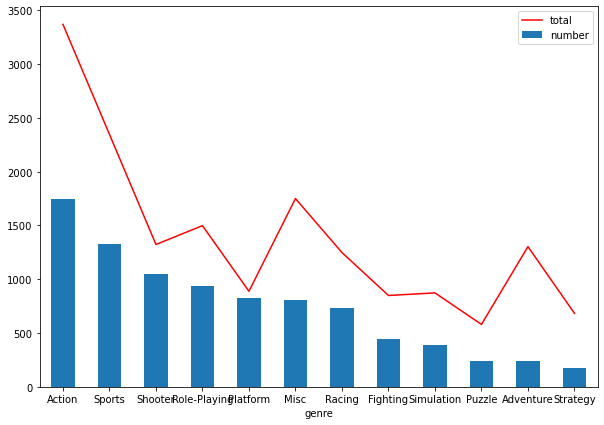

In [47]:
genres_grouped = games_new.pivot_table(index='genre',
                                     values='total_sales',
                                     aggfunc=['count','sum', 'mean']).reset_index()
genres_grouped.columns = ['genre', 'number', 'total', 'mean']
genres_grouped.sort_values(by='total', ascending=False, inplace=True)
ax = genres_grouped.plot(x='genre', y='total', kind='bar', figsize=(10,7))
genres_grouped.plot(x='genre', y='number', kind='line', color='red', figsize=(10,7), ax=ax)
plt.show()

**Action, Sports, RPG** are the most popular and profitable, Shooters are profitable, but little bit less popular. On the other side of the chart are **Strategies, Adventures and Puzzles**.   
I think this distribution could be explained by the content and production of each genre:
- Action, Sports, RPG, Shooters are usually quite expensive for development and production, and consequently it reflects on the price of each games
- Strategies, Adventures and Puzzles are more of 'indie', niche games from independent studios. They require less and they are less popular among gamers

[back to contents](#contents)

### Regional research <a class="anchor" id="chapter4"></a>

In [48]:
top5_plat = games_1995.groupby('platform')['total_sales'].sum()
top5_plat.sort_values(ascending=False).head()

platform
PS2     1246.54
X360     962.37
PS3      929.80
Wii      900.98
DS       801.59
Name: total_sales, dtype: float64

In [49]:
top5 = games_1995.query('platform in ("PS2", "X360", "PS3", "Wii", "DS")')
top5.head()
len(top5)

8116

In [50]:
top_5_NA = top5.pivot_table(index='platform',
                                     values='na_sales',
                                     aggfunc=['sum'])
top_5_NA.columns=['NA']

top_5_EU = top5.pivot_table(index='platform',
                                     values='eu_sales',
                                     aggfunc=['sum'])
top_5_EU.columns=['EU']

top_5_JP = top5.pivot_table(index='platform',
                                     values='jp_sales',
                                     aggfunc=['sum'])
top_5_JP.columns=['JP']

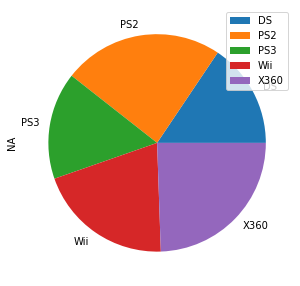

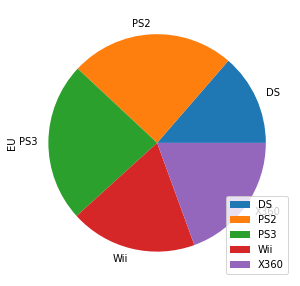

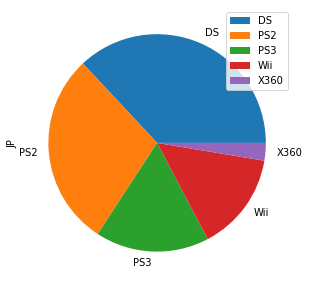

In [51]:
top_5_NA.plot.pie(y='NA', figsize=(5,5))
plt.show()
top_5_EU.plot.pie(y='EU', figsize=(5,5))
plt.show()
top_5_JP.plot.pie(y='JP', figsize=(5,5))
plt.show()

As for platforms, European and Noth American markets look similar, only the Xbox 360 is little bit more popular among Americans than among Europeans. Japanese market is different, it is obviously Nintendo country with the niggest DS share.

In [52]:
top5_genres = games_1995.groupby('genre')['total_sales'].sum()
top5_genres.sort_values(ascending=False).head(6)

genre
Action          1651.11
Sports          1272.93
Shooter          970.31
Role-Playing     882.80
Misc             771.98
Racing           693.27
Name: total_sales, dtype: float64

In [53]:
top_genres = games_1995.query('genre in ("Action", "Sports", "Shooter", "Role-Plying", "Racing")')

In [54]:
genre_5_NA = top_genres.pivot_table(index='genre',
                                     values='na_sales',
                                     aggfunc=['sum'])
genre_5_NA.columns=['NA']

genre_5_EU = top_genres.pivot_table(index='genre',
                                     values='eu_sales',
                                     aggfunc=['sum'])
genre_5_EU.columns=['EU']

genre_5_JP = top_genres.pivot_table(index='genre',
                                     values='jp_sales',
                                     aggfunc=['sum'])
genre_5_JP.columns=['JP']

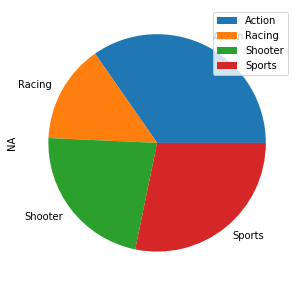

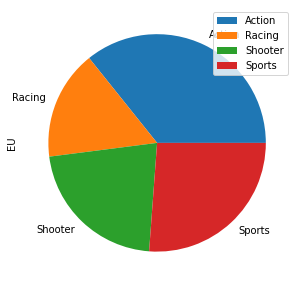

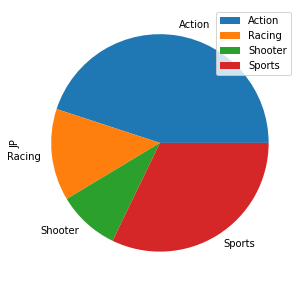

In [55]:
genre_5_NA.plot.pie(y='NA', figsize=(5,5))
plt.show()
genre_5_EU.plot.pie(y='EU', figsize=(5,5))
plt.show()
genre_5_JP.plot.pie(y='JP', figsize=(5,5))
plt.show()

Again as with platforms with genres market of EU and North America are quite similar. Japanese gamers are into Actions and Sportt games while Europeans and Americans are interested also in Shooters.

- **Do ESRB ratings affect sales in individual regions?**

In [56]:
esrb_NA = games_1995.pivot_table(index='rating',
                                     values='na_sales',
                                     aggfunc=['sum'])
esrb_NA.columns=['NA']

esrb_EU = games_1995.pivot_table(index='rating',
                                     values='eu_sales',
                                     aggfunc=['sum'])
esrb_EU.columns=['EU']

esrb_JP = games_1995.pivot_table(index='rating',
                                     values='jp_sales',
                                     aggfunc=['sum'])
esrb_JP.columns=['JP']

In [57]:
result = pd.concat([esrb_NA, esrb_EU,esrb_JP], axis=1, join='outer')
result.columns = ['NA', 'EU', 'JP']

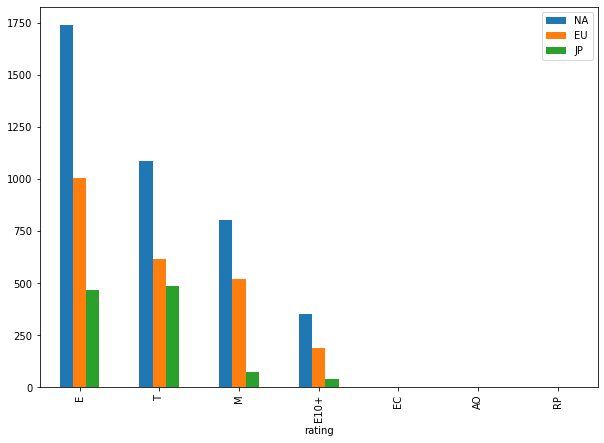

In [58]:
result.sort_values(by='NA', ascending=False).plot(kind='bar', figsize=(10,7))
plt.show()

- **'E'** - games for eveyrone - as soon as they are suitable for any kind of audience, it is the most 'saleable' games. 
- **'T'** - games for teenagers. it is a big share of gaming audience. And and Japan the total is litte bit higher comparing to 'E' which could mean that teens play there more.
- **'M'** - game for matures. Usually it is violent games like shooters and here we see significant difference between Western and Japanese markets - very small share of sales from games for this kind of games.  
Other scores are not so influential to the total sales.

### Testing hypotheses <a class="anchor" id="chapter5"></a>

>AVERAGE USER RATINGS OF THE XBOX ONE AND PC PLATFORMS ARE THE SAME


Hypotheses are formulated basing on the given comparing parameter (user_rating) and the stastical approach to compare two independent samples.  
**NULL**: The average user score from users of Xbox One equals the average user score from users of PC  
**ALTERNATIVE**: The average user score from users of Xbox One does not equal the average user score from users of PC  

As for the significance level I will take 5%.

In [59]:
xbox_one = games_new[games_new['platform'] == 'XOne']
pc = games_new[games_new['platform'] == 'PC']

In [60]:
user_rating = games_new.pivot_table(index=['platform'], values='user_score', aggfunc=['mean', 'median'])
user_rating.columns = ['mean', 'median']
user_rating.reset_index(level=0, inplace=True)
user_rating_pc_xone = user_rating.query('platform in ("PC", "XOne")').reset_index()

xbox_std = xbox_one['user_score'].std()
pc_std = pc['user_score'].std()
std = pd.DataFrame([[xbox_std, pc_std]],
                   columns=['xbox_std', 'pc_std'])
std = std.T
std.columns = ['std']
std.reset_index(level=0, inplace=True)
platforms = pd.concat([user_rating_pc_xone, std], join='outer', axis=1).drop(columns=['index'])
platforms['var'] = platforms['std'] ** 2
platforms

,platform,mean,median,std,var
0,PC,7.146253,7.5,1.288631,1.660571
1,XOne,6.741093,7.1,1.392418,1.938827


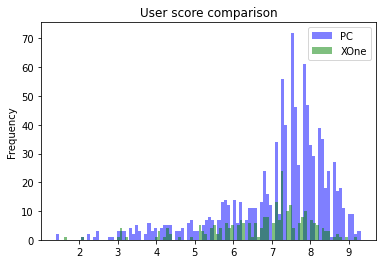

In [61]:
user_score_xone = games_new.loc[games_new['platform'] =='XOne', 'user_score']
user_score_pc = games_new.loc[games_new['platform'] =='PC', 'user_score']
kwargs = dict(alpha=0.5, bins=100)
plt.hist(user_score_pc, **kwargs, color='b', label='PC')
plt.hist(user_score_xone, **kwargs, color='g', label='XOne')
plt.gca().set(title='User score comparison', ylabel='Frequency')
plt.legend()
plt.show()

In [62]:
xone_h1 = xbox_one[['user_score']]
pc_h1 = pc[['user_score']]
alpha = .05
results = st.ttest_ind(
        xone_h1,
        pc_h1)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: [3.63539752e-05]
We reject the null hypothesis


PC players seem to be more loyal gamers - their average score are higher than scores of Xbox One users, and its confirmed by t-test. And is seems that PC players in general leave more reviews and scores than console players.

>AVERAGE USER RATINGS FOR THE ACTION AND SPORTS GENRES ARE DIFFERENT

**NULL**: The average user score from Action players equals the average user scores from Sport players 
**ALTERNATIVE**: The average user score from Action players does not equal the average user scores from Sport players 

As for the significance level I will take 5%.

In [63]:
action = games_new[games_new['genre'] == 'Action']
sport = games_new[games_new['genre'] == 'Sports']

In [64]:
user_score = games_new.pivot_table(index=['genre'], values='user_score', aggfunc=['mean', 'median'])
user_score.columns = ['mean', 'median']
user_score.reset_index(level=0, inplace=True)
user_rating_act_sport = user_score.query('genre in ("Action", "Sports")').reset_index()

action_std = action['user_score'].std()
sport_std = sport['user_score'].std()
std1 = pd.DataFrame([[action_std, sport_std]],
                   columns=['action_std', 'sport_std'])
std1 = std1.T
std1.columns = ['std']
std1.reset_index(level=0, inplace=True)
genres = pd.concat([user_rating_act_sport, std1], join='outer', axis=1).drop(columns=['index'])
genres['var'] = platforms['std'] ** 2
genres

,genre,mean,median,std,var
0,Action,7.130499,7.3,1.12761,1.660571
1,Sports,7.135386,7.4,1.22526,1.938827


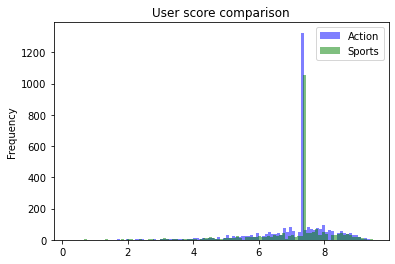

In [65]:
user_score_action = games_new.loc[games_new['genre'] =='Action', 'user_score']
user_score_sports = games_new.loc[games_new['genre'] =='Sports', 'user_score']
kwargs = dict(alpha=0.5, bins=100)
plt.hist(user_score_action, **kwargs, color='b', label='Action')
plt.hist(user_score_sports, **kwargs, color='g', label='Sports')
plt.gca().set(title='User score comparison', ylabel='Frequency')
plt.legend()
plt.show()

In [66]:
action_h1 = action[['user_score']]
sports_h1 = sport[['user_score']]
alpha = .05
results = st.ttest_ind(
        action_h1,
        sports_h1)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: [0.87641352]
We can't reject the null hypothesis


Here the situation is absolutely different. The user scores of Action game players and Sports players are almost the same - on histogram the profiles of each genre are almost the same. I also checked the 1% level of significance, but still it doesnt help. The users scores between these genres are pretty common.

### General conclusions <a class="anchor" id="chapter2"></a>

Game market is extremely interesing as I see!  
Which insights could help the plan the campaign for 2017:  
- Platforms are always competing, **PS2** is one of the most successful consoles. However, now there are **PS4, XOne** who are new and capturing their markets. So I assume these are the perspetive platforms for the future launches. However, users of PS2, Xbox 360, Nintendo Wii are still playing, so they could be accounted in future sales.  
- As for genres, **Action, Sports and Shooters** are the most profitable and demanded by players. "Indie" games are also worth for promotion, although they bring less profit - but they still have their aduience.
- Markets - I assume promotion in **EU and North America** could be similar because gamers behvaior is common. But **Japan** should be taken in more thorough consideration - they dont like shooters and adult games, games for Teens are more favorable.
- User / critic scores do not really affect on the sales